## 1) Car Not-Car Training Data

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


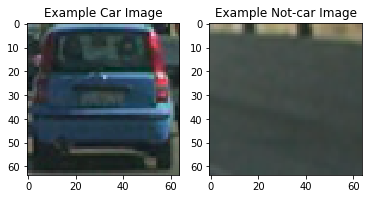

In [50]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
#from skimage.feature import hog
#from skimage import color, exposure

nvi_extra = glob.glob('./training_data/non-vehicles/Extras/*.png')
nvi_gti = glob.glob('./training_data/non-vehicles/GTI/*.png')
nvi_mrl = glob.glob('./training_data/non-vehicles/mrl/*.png')
vi_gti_far = glob.glob('./training_data/vehicles/GTI_Far/*.png')
vi_gti_left = glob.glob('./training_data/vehicles/GTI_Left/*.png')
vi_gti_mc = glob.glob('./training_data/vehicles/GTI_MiddleClose/*.png')
vi_gti_right = glob.glob('./training_data/vehicles/GTI_Right/*.png')
vi_kitti_extracted = glob.glob('./training_data/vehicles/KITTI_extracted/*.png')

cars = []
notcars = []

# images are divided up into non-vehicles
for image in nvi_extra: notcars.append(image)
for image in nvi_gti: notcars.append(image)
# images are divided up into vehicles
for image in vi_gti_far: cars.append(image)
for image in vi_gti_left: cars.append(image)
for image in vi_gti_mc: cars.append(image)
for image in vi_gti_right: cars.append(image)
for image in vi_kitti_extracted: cars.append(image)
        
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
#plt.savefig('./examples/car_not_car_mrl.png')


## 2) Hog Heaven (functions)

In [51]:
# 35. Hog Sub-sampling Window Search lesson_functions.py
import numpy as np
import cv2
#--- squelch deprecation warnings from skimage.feature.hog
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
#--- squelch deprecation warnings from skimage.feature.hog
from skimage.feature import hog

def norm_rgb_image(crze_image):
    return ((crze_image / 255.0) - 0.5).astype(np.float32)

def get_rgb_image(file, norm=False):
    #image = mpimg.imread(file) # Friends don't let friends do this

    # Use method that always returns RGB in range 0-255 (uint8)
    int_image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    if (norm): return norm_rgb_image(int_image)
    else: return int_image

def convert_color(img, conv='YCrCb'):
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif conv == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec,
                                  block_norm="L2-Hys")
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec,
                       block_norm="L2-Hys")
        return features

# Define a function to compute binned color features  
def bin_spatial_orig(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features                       

def color_hist(img, nbins=32, bins_range=(0, 256)):    #bins_range=(0, 256) for mpimage.png
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, spatial_size=(32, 32),
                           hist_bins=32, hist_range=(0, 256),
                           pix_per_cell=8, cell_per_block=2,
                           hog_channel=0, feature_vec=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = get_rgb_image(file, norm=True)
        file_features = []

        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            feature_image = convert_color(image, conv=cspace)
        else: feature_image = np.copy(image)      

        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)

        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        file_features.append(hist_features)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=feature_vec))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=feature_vec)
        file_features.append(hog_features)

        # Append the new feature vector to the features list
        features.append(np.concatenate(file_features))

    # Return list of feature vectors
    return features

print("fini...")

fini...


### 2a) Params and Color Spaces Example

Current rcParams figure size: [6.0, 4.0]


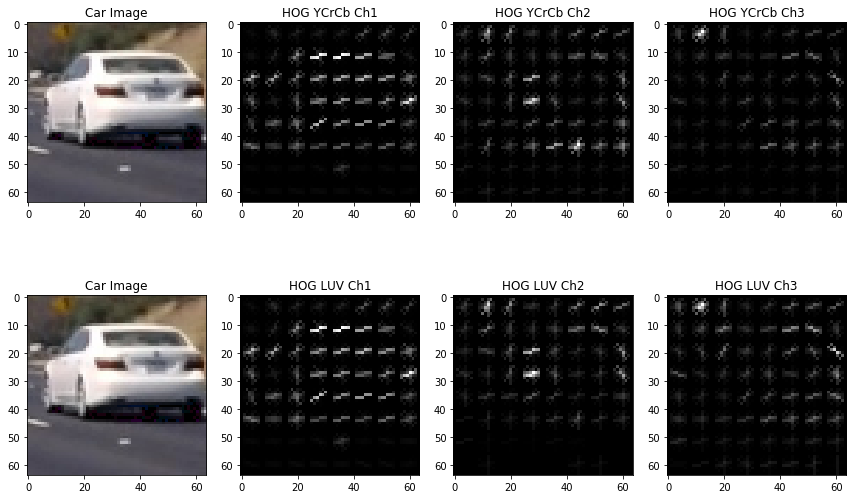

In [52]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
#image = get_rgb_image(cars[ind])
image = get_rgb_image('./test_images/car_not_found_mrl.jpg')

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

ctrans_tosearch = convert_color(image, conv='YCrCb')
ch1 = ctrans_tosearch[:,:,0]
ch2 = ctrans_tosearch[:,:,1]
ch3 = ctrans_tosearch[:,:,2]
# Compute individual channel HOG features for the entire image
hog1, hog11_image = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
hog2, hog12_image = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
hog3, hog13_image = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

ctrans_tosearch_luv = convert_color(image, conv='LUV')
ch1_luv = ctrans_tosearch_luv[:,:,0]
ch2_luv = ctrans_tosearch_luv[:,:,1]
ch3_luv = ctrans_tosearch_luv[:,:,2]
# Compute individual channel HOG features for the entire image
hog21, hog21_image = get_hog_features(ch1_luv, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
hog22, hog22_image = get_hog_features(ch2_luv, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
hog23, hog23_image = get_hog_features(ch3_luv, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

# Get current size
fig_size = plt.rcParams["figure.figsize"]
print ("Current rcParams figure size:", fig_size)
# Set figure width to 12 and height to 8
fig_size = [12,8]
plt.rcParams["figure.figsize"] = fig_size

# Plot the examples
f, axarr = plt.subplots(2, 4)

#plt.subplot(141)
axarr[0, 0].imshow(image, cmap='gray')
axarr[0, 0].set_title('Car Image')
#plt.subplot(142)
axarr[0, 1].imshow(hog11_image, cmap='gray')
axarr[0, 1].set_title('HOG YCrCb Ch1')
#plt.subplot(143)
axarr[0, 2].imshow(hog12_image, cmap='gray')
axarr[0, 2].set_title('HOG YCrCb Ch2')
#plt.subplot(144)
axarr[0, 3].imshow(hog13_image, cmap='gray')
axarr[0, 3].set_title('HOG YCrCb Ch3')

#plt.subplot(241)
axarr[1, 0].imshow(image, cmap='gray')
axarr[1, 0].set_title('Car Image')
#plt.subplot(242)
axarr[1, 1].imshow(hog21_image, cmap='gray')
axarr[1, 1].set_title('HOG LUV Ch1')
#plt.subplot(243)
axarr[1, 2].imshow(hog22_image, cmap='gray')
axarr[1, 2].set_title('HOG LUV Ch2')
#plt.subplot(244)
axarr[1, 3].imshow(hog23_image, cmap='gray')
axarr[1, 3].set_title('HOG LUV Ch3')
plt.tight_layout() # Adjust subplots to not overlap
#plt.savefig('./examples/HOG_example_mrl.png')


## 3) Train SVM

In [53]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# from sklearn.cross_validation import train_test_split
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split

# Relies on cars[] and notcars[] being defined earlier in "1) Car Not-Car Training Data"
# cars = [], notcars = []

# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
sample_size = 500
cars_sample = cars[0:sample_size]
notcars_sample = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
colorspace = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)
hist_bins = 32
hist_range = (0, 256)

t=time.time()

car_features = extract_features(cars_sample,
                        cspace=colorspace, orient=orient, spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=hist_range,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, feature_vec=True)
notcar_features = extract_features(notcars_sample,
                        cspace=colorspace, orient=orient, spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=hist_range,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, feature_vec=True)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts:     ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

16.96 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
1.0 Seconds to train SVC...
Test Accuracy of SVC =  0.98
My SVC predicts:      [ 1.  1.  0.  0.  1.  1.  1.  0.  1.  1.]
For these 10 labels:  [ 1.  1.  0.  0.  1.  0.  1.  0.  1.  1.]
0.00665 Seconds to predict 10 labels with SVC


#### Debug PNG vs JPG

nw ['./test_images/car_not_found_mrl.png', './training_data/non-vehicles/Extras/extra1000.png']
scaled_Xnw[0] [-0.66008918  0.29074652  0.33499442 ..., -0.04827858 -0.03981778
 -0.0352858 ]
scaled_Xnw[1] [ 0.22725733 -0.82506277 -0.82159486 ..., -0.04827589 -0.03981561
 -0.03528472]
My SVC predicts:      [ 1.]
My SVC predicts:      [ 0.]
nw types uint8 uint8
nw1 min(), max()= 0 255
nw2 min(), max()= 22 253
nw1 shape= (64, 64, 3)
nw2 shape= (64, 64, 3)


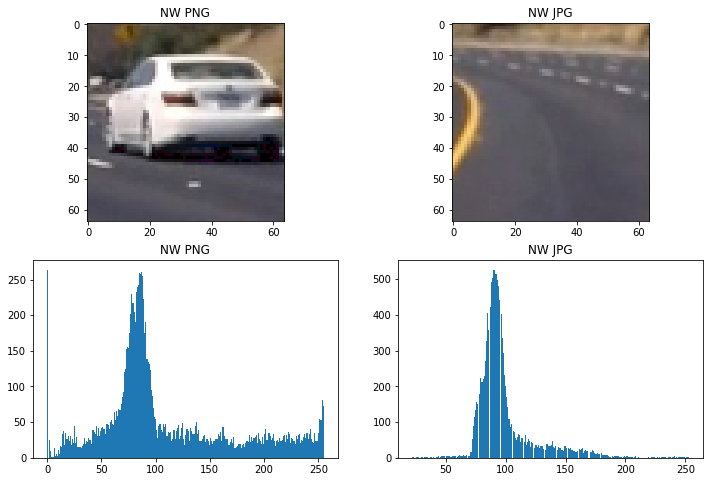

In [54]:
#print("cars_sample[0]",cars_sample[0])
#print("X_test[0]",X_test[0])
nw = []
nw.append('./test_images/car_not_found_mrl.png')
#nw.append('./training_data/vehicles/GTI_MiddleClose/image0066.png')
nw.append('./training_data/non-vehicles/Extras/extra1000.png')
#nw.append('./test_images/car_not_found_mrl.jpg')
print("nw",nw)

dcolorspace = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#dcolorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)
hist_bins = 32
hist_range = (0, 256)

nw_features = extract_features(nw,
                        cspace=colorspace,
                        orient=9,
                        pix_per_cell=8,
                        cell_per_block=2,
                        hog_channel='ALL',
                        spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),
                        feature_vec=True)

# Create an array stack of feature vectors
Xnw = np.vstack((nw_features)).astype(np.float64)                        
#Xnw = np.array(nw_features).reshape(1, -1)
# Fit a per-column scaler
#Xnw_scaler = StandardScaler().fit(Xnw)

# Apply the scaler (Used for Training) to X
scaled_Xnw = X_scaler.transform(Xnw)
print("scaled_Xnw[0]",scaled_Xnw[0])
if (len(scaled_Xnw) > 1): print("scaled_Xnw[1]",scaled_Xnw[1])

print('My SVC predicts:     ', svc.predict(scaled_Xnw[0]))
if (len(scaled_Xnw) > 1): print('My SVC predicts:     ', svc.predict(scaled_Xnw[1]))

fig = plt.figure()

# Read in each one by one
nw1_oimage = get_rgb_image(nw[0])
#nw1_nimage = (nw1_oimage / np.mean(nw1_oimage)).astype(np.uint8)
# Normalised [0,255] as integer
#nw1_nimage = (255*(nw1_oimage - np.max(nw1_oimage))/-np.ptp(nw1_oimage)).astype(np.uint8)
#nw1_nimage = (nw1_oimage * (255.0 / nw1_oimage.max())).astype(np.uint8)
#nw1_nimage = ((100.0/200) * nw1_oimage + 100).astype(np.uint8)
nw1_image = convert_color(nw1_oimage, conv=dcolorspace)

if (len(scaled_Xnw) > 1): nw2_oimage = get_rgb_image(nw[1])
nw2_image = convert_color(nw2_oimage, conv=dcolorspace)
print("nw types",nw1_oimage.dtype, nw2_oimage.dtype)
print("nw1 min(), max()=",nw1_oimage.min(),nw1_oimage.max())
print("nw2 min(), max()=",nw2_oimage.min(),nw2_oimage.max())
print("nw1 shape=",nw1_oimage.shape)
print("nw2 shape=",nw2_oimage.shape)

plt.subplot(221)
plt.imshow(cv2.cvtColor(nw1_image, cv2.COLOR_LUV2RGB))
plt.title('NW PNG')
plt.subplot(222)
plt.imshow(cv2.cvtColor(nw2_image, cv2.COLOR_LUV2RGB))
plt.title('NW JPG')
plt.subplot(223)
plt.hist(nw1_oimage.ravel(), bins=256)
plt.title('NW PNG')
plt.subplot(224)
plt.hist(nw2_oimage.ravel(), bins=256)
plt.title('NW JPG')


## 4) Find Cars

nxblocks, nyblocks, nfeat_per_block 105 20 36
window, nblocks_per_window, cells_per_step 64 7 2
nxsteps, nysteps 49 6


NameError: name 'sub_img' is not defined

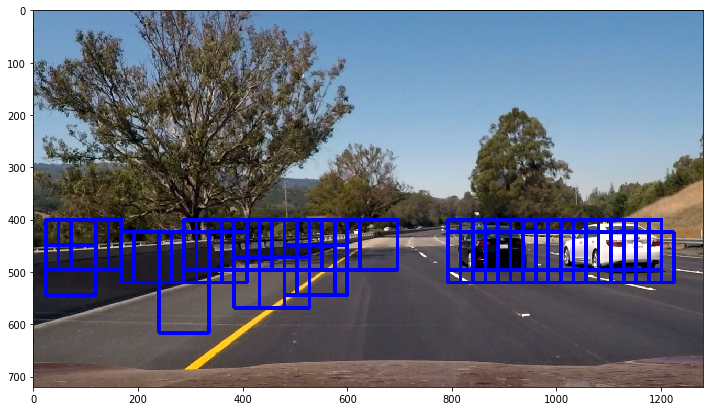

In [107]:
# 35. Hog Sub-sampling Window Search hog_subsample.py
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

#img = get_rgb_image('./test_images/test1.jpg')
#img = get_rgb_image('./test_images/test2.jpg')
#img = get_rgb_image('./test_images/test3.jpg')
#img = get_rgb_image('./test_images/test4.jpg')
#img = get_rgb_image('./test_images/test5.jpg')
img = get_rgb_image('./test_images/test6.jpg')

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = norm_rgb_image(draw_img)
    fsub_image = []
    
    img_tosearch = img[ystart:ystop,:,:]
    #ctrans_tosearch = convert_color(img_tosearch, conv='YCrCb')
    ctrans_tosearch = convert_color(img_tosearch, conv='LUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    print("nxblocks, nyblocks, nfeat_per_block",nxblocks,nyblocks,nfeat_per_block)
    print("window, nblocks_per_window, cells_per_step",window,nblocks_per_window,cells_per_step)
    print("nxsteps, nysteps",nxsteps,nysteps)
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            #if one_time:
            #    print("lens=",(len(list(spatial_features.shape)) != len(list(hist_features.shape))))
            #if (len(list(spatial_features.shape)) != len(list(hist_features.shape))):
            #    print("spatial_features.shape=",spatial_features.shape)
            #    print("hist_features.shape=",hist_features.shape)
            #    print("hog_features.shape=",hog_features.shape)
            #    one_time = False

            # Scale features and make a prediction
            #X_s = np.hstack((spatial_features)).reshape(1, -1)
            #X_s_ho = np.hstack((spatial_features, hog_features)).reshape(1, -1)
            X_s_hi_ho = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_features = X_scaler.transform(X_s_hi_ho)    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)

            #if (xb == 36 and yb == 0):
            #    print("XB 36: test_prediction,xb,yb",test_prediction,xb,yb)
            #    sub_image = subimg

            if test_prediction == 1:
                #print("Found test_prediction,xb,yb",test_prediction,xb,yb)
                collect_bad = False
                if (xb < 32 and xb < 49 and collect_bad):
                    file_name = './training_data/non-vehicles/mrl/t6_bad_find_car_'+str(xb)+'-'+str(yb)+'.png'
                    rfile_name = './training_data/non-vehicles/mrl/t6_bad_find_car_'+str(xb)+'-'+str(yb)+'r.png'
                    plt.imsave(fname=file_name,arr=cv2.cvtColor(subimg, cv2.COLOR_LUV2RGB))
                    plt.imsave(fname=rfile_name,arr=cv2.flip(cv2.cvtColor(subimg, cv2.COLOR_LUV2RGB),1))
                #fsub_image = subimg
                if (xb > 0 and xb < 49):
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 

    return draw_img
    #return draw_img, ctrans_tosearch
    #return draw_img, sub_image, fsub_image
    
ystart = 400
ystop = 656
#ystop = 520
scale = 1.5
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)
hist_bins = 32
hist_range = (0, 256)
one_time = True
    
#out_img, sub_img, fsub_img = find_cars(img,
out_img = find_cars(img,
                    ystart=ystart, ystop=ystop, scale=scale,
                    svc=svc, X_scaler=X_scaler, orient=orient,
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                    spatial_size=spatial_size, hist_bins=hist_bins)

plt.imshow(out_img)
plt.imsave(fname='./examples/sliding_window_mrl.png',arr=cv2.cvtColor(sub_img, cv2.COLOR_LUV2RGB))
#plt.imsave(fname='./test_images/car_not_found_mrl.jpg',arr=cv2.cvtColor(sub_img, cv2.COLOR_LUV2RGB))

# Plot the examples
#fig = plt.figure()

#plt.subplot(311)
#plt.imshow(cv2.cvtColor(sub_img, cv2.COLOR_LUV2RGB))
#plt.title('Sub Image')

#plt.subplot(312)
#if fsub_img:
#    plt.imshow(cv2.cvtColor(fsub_img, cv2.COLOR_LUV2RGB))
#else: plt.imshow(np.zeros_like(sub_img))
#plt.title('Found Sub Image')

#plt.subplot(313)
#plt.imshow(out_img)
#plt.title('Image')
#plt.tight_layout() # Adjust subplots to not overlap



## 5) Sliding Window & Draw Boxes

In [62]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

print("fini...")

fini...


## 6) Search Windows

In [83]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
#from sklearn.svm import LinearSVC
#from sklearn.preprocessing import StandardScaler
#from skimage.feature import hog
#from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []

    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        feature_image = convert_color(img, conv=color_space)
    else: feature_image = np.copy(img)  
            
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='LUV', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

print("fini...")

fini...


## 7) Heat

In [158]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold_clip(heatmap, threshold, clip):
    # Zero out pixels below the threshold and set others to clip
    heatmap[heatmap <= threshold] = 0
    heatmap[heatmap > 0] = clip
    # Return thresholded map
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def total_heat(heatmaps):
    # Iterate through all heatmaps.  Requires at least 1 heatmap or boom
    hm_sum = heatmaps[0]
    if len(heatmaps) > 1:
        for x in range(1, len(heatmaps)-1):
            hm_sum += heatmaps[x]
    return hm_sum
            
print("fini...")

fini...


## 8) Process Image

In [178]:
pcolorspace = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
porient = 9
ppix_per_cell = 8
pcell_per_block = 2
phog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
pspatial_size = (32, 32)
phist_bins = 32
phist_range = (0, 256)
pspatial_feat=True
phist_feat=True
phog_feat=True
pthreshold = 5
pclip = 1

def process_image(input_image):
    global pi_first_time, output_sample, heatmaps
    if pi_first_time:
        pi_first_time = False
        print (input_image.shape, input_image.dtype)
        #print('input_image[:,:,0]',input_image[:,:,0])
    
    draw_image = np.copy(input_image)
    pi_input_image = norm_rgb_image(draw_image)
    #heat = np.zeros_like(input_image[:,:,0]).astype(np.float)
    heat = np.zeros_like(input_image[:,:,0]).astype(np.uint)

    x_start_stop = [[500, 800], [500, 1100], [690, draw_image.shape[1]]]
    y_start_stop = [[380, 460], [390, 550], [380, 656]] # Min and max in y to search in slide_window()

    windows = slide_window(pi_input_image, x_start_stop=x_start_stop[0], y_start_stop=y_start_stop[0], 
                        xy_window=(80, 80), xy_overlap=(0.75, 0.75))
    windows += slide_window(pi_input_image, x_start_stop=x_start_stop[1], y_start_stop=y_start_stop[1], 
                        xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    windows += slide_window(pi_input_image, x_start_stop=x_start_stop[2], y_start_stop=y_start_stop[2], 
                        xy_window=(128, 128), xy_overlap=(0.75, 0.75))

    hot_windows = search_windows(pi_input_image, windows, svc, X_scaler, color_space=pcolorspace, 
                            spatial_size=pspatial_size, hist_bins=phist_bins, 
                            orient=porient, pix_per_cell=ppix_per_cell, 
                            cell_per_block=pcell_per_block, 
                            hog_channel=phog_channel, spatial_feat=pspatial_feat, 
                            hist_feat=phist_feat, hog_feat=phog_feat)                       

    #window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)
    heat = apply_threshold_clip(heat, pthreshold, pclip)

    ## Utilize deque
    heatmaps.append(heat)
    heatmap_sum = total_heat(heatmaps)

    #print("b:",np.amin(heatmap_sum),np.amax(heatmap_sum))
    # Apply threshold to help remove false positives
    pi_heatmap = apply_threshold(heatmap_sum, 2)
    #print("a:",np.amin(heatmap_sum),np.amax(heatmap_sum))
    #print("-")

    # Find final boxes from heatmap using label function
    #labels = label(heat)

    # Visualize the heatmap when displaying    
    pi_heatmap = np.clip(pi_heatmap, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(pi_heatmap)

    draw_img = draw_labeled_bboxes(draw_image, labels)
    
    if (output_sample < 12):
        output_sample += 1
        if (output_sample > 5):
            #print (heat.shape, heat.dtype)

            cv2.rectangle(draw_image, (x_start_stop[0][0],y_start_stop[0][0]), (x_start_stop[0][1],y_start_stop[0][1]), (255,0,255), 4)
            cv2.rectangle(draw_image, (x_start_stop[1][0],y_start_stop[1][0]), (x_start_stop[1][1],y_start_stop[1][1]), (255,255,0), 3)
            cv2.rectangle(draw_image, (x_start_stop[2][0],y_start_stop[2][0]), (x_start_stop[2][1],y_start_stop[2][1]), (0,255,255), 2)

            # Plot the examples
            fig = plt.figure()

            plt.subplot(131)
            plt.imshow(draw_img)
            plt.title('Draw Image')

            plt.subplot(132)
            plt.imshow(labels[0], cmap='gray')
            plt.title('Labels:'+str(labels[1]))

            plt.subplot(133)
            # Visualize the heatmap when displaying    
            #heatmap_img = np.clip(heat, 0, 255)
            #plt.imshow(heatmap_img, cmap='hot')
            plt.imshow(pi_heatmap, cmap='hot')
            plt.title('Heat')

            plt.tight_layout() # Adjust subplots to not overlap
            plt.savefig('./examples/bboxes_and_heat_mrlp'+str(output_sample)+'.png')

    return draw_img

print("fini...")

fini...


## 9) Process Video

(720, 1280, 3) uint8
[MoviePy] >>>> Building video output_images/project5_video_clip.mp4
[MoviePy] Writing video output_images/project5_video_clip.mp4


 98%|█████████▊| 50/51 [01:51<00:02,  2.06s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project5_video_clip.mp4 

CPU times: user 1min 50s, sys: 3.3 s, total: 1min 53s
Wall time: 1min 52s


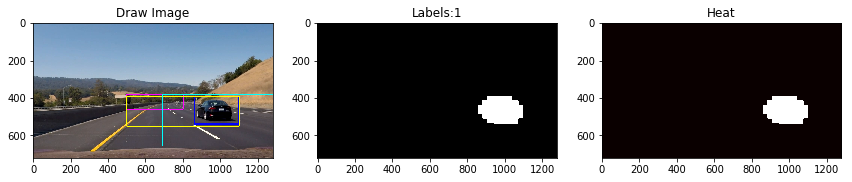

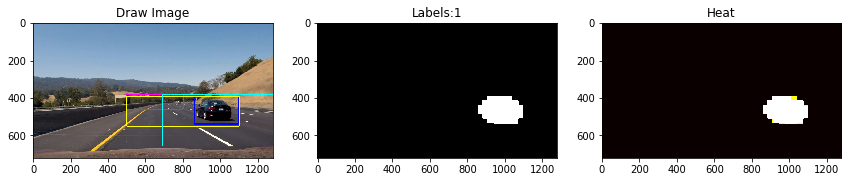

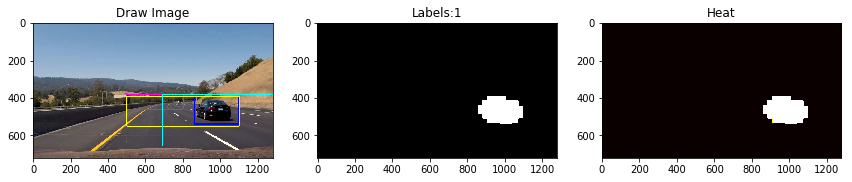

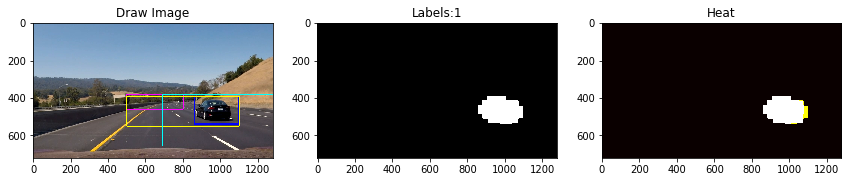

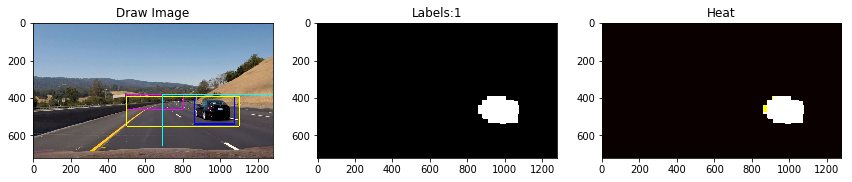

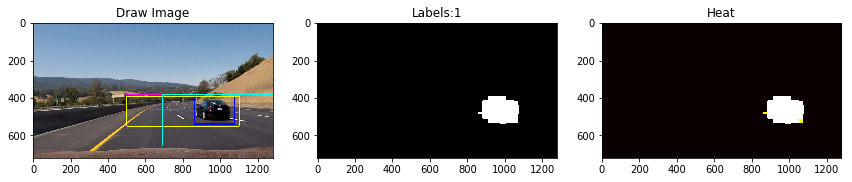

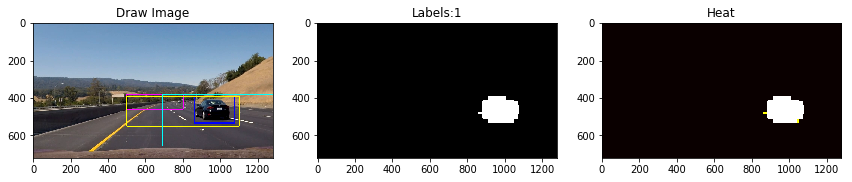

In [179]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import datetime, time
from collections import deque

test_video = False
clip = True
output_sample = 0
pi_first_time = True
heatmaps = deque(maxlen=5)

clip1 = VideoFileClip("project_video.mp4")
white_output = 'output_images/project5_video.mp4'

if (test_video): 
    clip1 = VideoFileClip("test_video.mp4")
    white_output = 'output_images/project5_test_video.mp4'
    if (clip):
        clip1 = VideoFileClip("test_video.mp4").subclip(0,1)
        white_output = 'output_images/project5_test_video_clip.mp4'
else:
    if (clip):
        clip1 = VideoFileClip("project_video.mp4").subclip(33,35)
        white_output = 'output_images/project5_video_clip.mp4'

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:


# Plot the examples
fig = plt.figure()
output_sample = 0

for input_image in glob.glob('test_images/test*.jpg'):
    draw_image = np.copy(input_image)
    pi_input_image = norm_rgb_image(draw_image)

    heat = np.zeros_like(draw_image[:,:,0]).astype(np.float)

    y_start_stop = [[380, 550],[380, 600],[380, 656]] # Min and max in y to search in slide_window()

    windows = slide_window(pi_input_image, x_start_stop=[690, None], y_start_stop=y_start_stop[0], 
                        xy_window=(80, 80), xy_overlap=(0.75, 0.75))
    windows += slide_window(pi_input_image, x_start_stop=[690, None], y_start_stop=y_start_stop[1], 
                        xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    windows += slide_window(pi_input_image, x_start_stop=[690, None], y_start_stop=y_start_stop[2], 
                        xy_window=(128, 128), xy_overlap=(0.75, 0.75))

    hot_windows = search_windows(pi_input_image, windows, svc, X_scaler, color_space=pcolorspace, 
                            spatial_size=pspatial_size, hist_bins=phist_bins, 
                            orient=porient, pix_per_cell=ppix_per_cell, 
                            cell_per_block=pcell_per_block, 
                            hog_channel=phog_channel, spatial_feat=pspatial_feat, 
                            hist_feat=phist_feat, hog_feat=phog_feat)                       

    #window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,5)

    # Find final boxes from heatmap using label function
    labels = label(heat)
    draw_img = draw_labeled_bboxes(draw_image, labels)
    
    if (output_sample < 6):
        output_sample += 1

        plt.subplot(620+output_sample)
        plt.imshow(draw_img)
        plt.title('Draw Image '+str(output_sample))

        plt.subplot(621+output_sample)
        plt.imshow(heat)
        plt.title('Heat')

plt.tight_layout() # Adjust subplots to not overlap
plt.savefig('./examples/bboxes_and_heat_mrl'+str(output_sample)+'.png')
        
print("fini...")

In [ ]:
# ALTERNATE COLOR SPACE PLOTING FOR 1xN images

# Get current size
fig_size = plt.rcParams["figure.figsize"]
print ("Current size:", fig_size)
# Set figure width to 12 and height to 8
fig_size = [12,8]
plt.rcParams["figure.figsize"] = fig_size

# Plot the examples
fig = plt.figure()

plt.subplot(141)
plt.imshow(image, cmap='gray')
plt.title('Car Image')
plt.subplot(142)
plt.imshow(hog11_image, cmap='gray')
plt.title('HOG YCrCb Ch1')
plt.subplot(143)
plt.imshow(hog12_image, cmap='gray')
plt.title('HOG YCrCb Ch2')
plt.subplot(144)
plt.imshow(hog13_image, cmap='gray')
plt.title('HOG YCrCb Ch3')

plt.subplot(241)
plt.imshow(image, cmap='gray')
plt.title('Car Image')
plt.subplot(242)
plt.imshow(hog21_image, cmap='gray')
plt.title('HOG LUV Ch1')
plt.subplot(243)
plt.imshow(hog22_image, cmap='gray')
plt.title('HOG LUV Ch2')
plt.subplot(244)
plt.imshow(hog23_image, cmap='gray')
plt.title('HOG LUV Ch3')
plt.tight_layout() # Adjust subplots to not overlap
